In [1]:
from tinyphysics import TinyPhysicsModel, TinyPhysicsSimulator, CONTROL_START_IDX
from controllers import pid, pidf
from matplotlib import pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np
from scipy import signal

ACC_G = 9.81

sns.set_theme()


/home/risak/controls_challenge/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


$a_{lat} = \beta_0 + \beta_1 * \frac{v^2 * sin(\gamma)}{L}$

steer_command $ = f_{steer}^{-1}(\delta) = arcsin(\frac{\frac{a_{lat} - \beta_0}{\beta_1}\cdot L}{v^2})$

In [19]:
datafile = "data/00392.csv"

df = pd.read_csv(datafile)
t = df["t"].to_numpy()[:100]
vEgo = df["vEgo"].to_numpy()[:100]
aEgo = df["aEgo"].to_numpy()[:100]
roll_la = np.sin(df["roll"].to_numpy()[:100]) * ACC_G
target_la = df["targetLateralAcceleration"].to_numpy()[:100]
steerCommands = -df["steerCommand"].to_numpy()[:100]
steer_la = target_la - roll_la

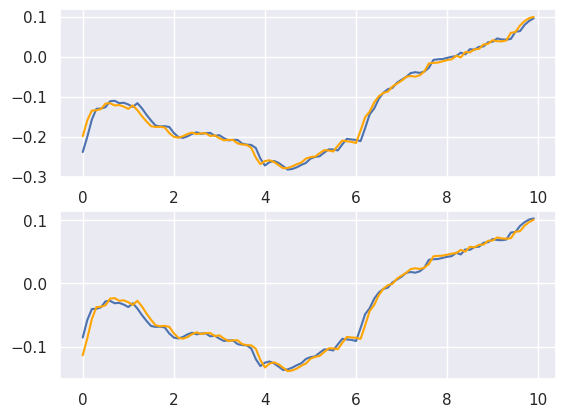

0.011248180705200473
beta0: -0.0769574481921961, beta1: 0.0027094010571292247


In [20]:
L = 1
steerAngle = lambda x: x

lag = 0
pred_la = vEgo[lag:] ** 2 * np.sin(steerAngle(steerCommands[:100-lag])) / L

beta1 = np.sum((pred_la - pred_la.mean()) * (steer_la[lag:] - steer_la[lag:].mean())) / np.sum((pred_la - pred_la.mean()) ** 2)
beta0 = steer_la.mean() - beta1 * pred_la.mean()

# beta1 = 0.002257592851869056
# beta0 = -0.04918295333364523

pred_la = beta0 + beta1 * pred_la
pred_steer = np.arcsin((steer_la[lag:] - beta0) / beta1 / vEgo[lag:] ** 2)
fig, ax = plt.subplots(2)
ax[0].plot(t[lag:], steer_la[lag:])
ax[0].plot(t[lag:], pred_la, color='orange')
ax[1].plot(t[:100-lag], steerCommands[:100-lag])
ax[1].plot(t[:100-lag], pred_steer, color='orange')
plt.show()

print(np.sum((pred_la - steer_la[lag:])**2))
print(f'beta0: {beta0}, beta1: {beta1}')

0


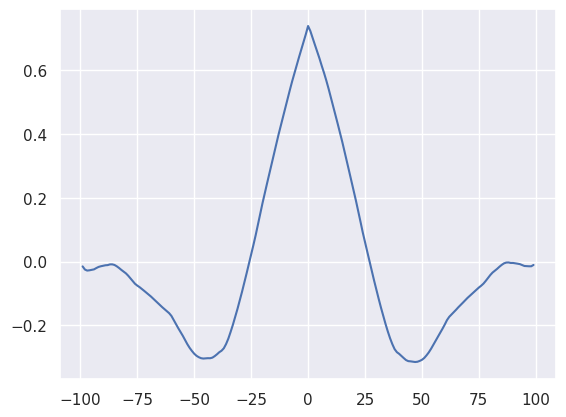

In [21]:
corr = signal.correlate(steer_la - steer_la.mean(), steerCommands - steerCommands.mean())
lags = signal.correlation_lags(100, 100)
print(lags[np.argmax(corr)])

plt.plot(lags, corr)
plt.show()

### Check data statistics

In [ ]:
import random

beta0s = []
beta1s = []
ssq_residuals = []

numbers = random.sample(range(0, 20000), 200)
for number in numbers:
    # Load data
    datafile = f"data/{str(number).zfill(5)}.csv"
    df = pd.read_csv(datafile)
    t = df["t"].to_numpy()[:100]
    vEgo = df["vEgo"].to_numpy()[:100]
    roll_la = np.sin(df["roll"].to_numpy()[:100]) * ACC_G
    target_la = df["targetLateralAcceleration"].to_numpy()[:100]
    steerCommands = -df["steerCommand"].to_numpy()[:100]
    steer_la = target_la - roll_la

    # Fit model
    pred_la = vEgo ** 2 * np.sin(steerCommands)

    beta1 = np.sum((pred_la - pred_la.mean()) * (steer_la - steer_la.mean())) / (np.sum((pred_la - pred_la.mean()) ** 2) + 1e-8)
    beta0 = steer_la.mean() - beta1 * pred_la.mean()

    pred_la = pred_la * beta1 + beta0
    
    beta0s.append(beta0)
    beta1s.append(beta1)
    ssq_residuals.append(np.sum((pred_la - steer_la)**2))

beta0s = np.array(beta0s)
beta1s = np.array(beta1s)
ssq_residuals = np.array(ssq_residuals)

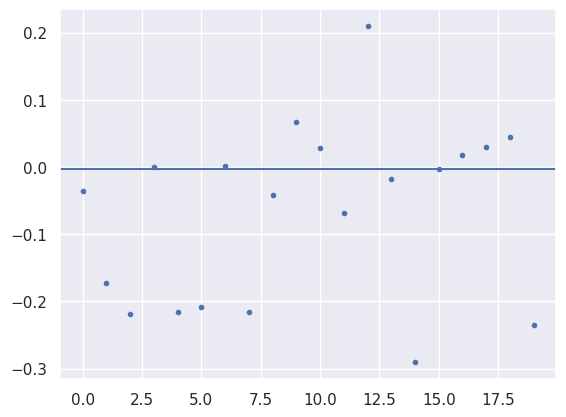

In [ ]:
plt.plot(np.random.choice(beta0s, 20), '.')
plt.axhline(np.median(beta0s))

In [ ]:
np.median(beta0s)

-0.04918295333364523

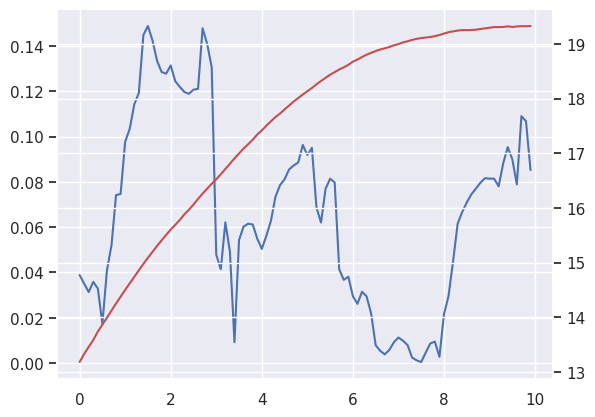

In [ ]:
fig, ax1 = plt.subplots()
ax1.plot(t, np.abs(steer_la - pred_la))
ax2 = ax1.twinx()
ax2.plot(t, np.abs(vEgo), color='r')
plt.show()

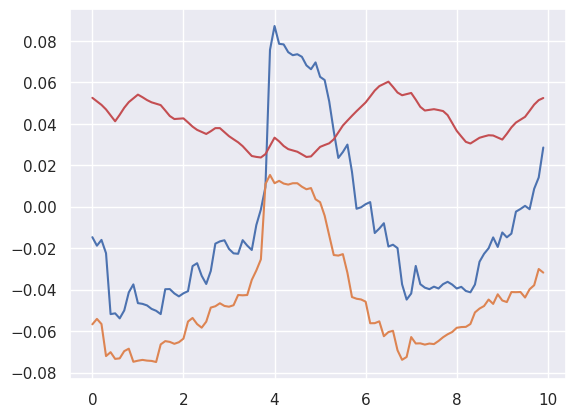

In [ ]:
plt.plot(t, target_la)
plt.plot(t, roll_la, color='r')
plt.plot(t, steerCommands)
plt.show()